# Analysis of Yelp Data

In this notebook, I will be anlayzing Yelp reviews using Spark. The dataset comes from Kaggle, and stored in S3

## 1. Installation and Setup

In [1]:
%info

### Installing the necessary packages that I will use during the analysis

In [2]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1606257222673_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/4a/6a/94b219b8ea0f2d580169e85ed1edc0163743f55aaeca8a44c2e8fc1e344e/pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d2/46/231de802ade4225b76b96cffe419cf3ce52bbe92e3b092cf12db7d11c207/kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl

  Usi

## 2.Importing Business Data

Data files for this project are saved in S3, in the JSON format.

In [3]:
business = spark.read.json("s3://sta9760project2/yelp_academic_dataset_business.json")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 3. Overview of Business Data

Displaying the number of rows and columns in the dataset

In [4]:
print("Columns:",len(business.columns)," | ","Rows:",business.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 14  |  Rows: 209393

Displaying schema of the data

In [5]:
business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Displaying the first 5 rows of data with the follwing columns:

    - business_id
    - name
    - city
    - state
    - categories

In [6]:
business.select('business_id','name','city','state','categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

## 4. Analyzing Categories

The "categories" column contains multiple category types that apply to each business id. In order to analyze categories, I will "explode" this column, and explore the following questions:

    - How many unique categories exist in the dataframe
    - How many businesses are categorized by "Active Life"
    - What are the top 20 most popular categories?

### Creating the Association Table

Before creating the association table, I will create a new variable that isolates the business_id and categories using the select() function. This new variable, business_cats, will be used to explode the categories column so that I can analyze category data

In [7]:
from pyspark.sql.functions import explode, split

business_cats = business.select('business_id','categories')

business_cats_exploded = business_cats.withColumn('category',explode(split('categories',",")))
num_rows = business_cats_exploded.count()
business_cats_exploded.show(10)
print("Total number of categories in the datatset:",num_rows)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+
|         business_id|          categories|            category|
+--------------------+--------------------+--------------------+
|f9NumwFMBDn751xgF...|Active Life, Gun/...|         Active Life|
|f9NumwFMBDn751xgF...|Active Life, Gun/...|    Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|Active Life, Gun/...|         Guns & Ammo|
|f9NumwFMBDn751xgF...|Active Life, Gun/...|            Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical,...|    Health & Medical|
|Yzvjg0SayhoZgCljU...|Health & Medical,...| Fitness & Instru...|
|Yzvjg0SayhoZgCljU...|Health & Medical,...|                Yoga|
|Yzvjg0SayhoZgCljU...|Health & Medical,...|         Active Life|
|Yzvjg0SayhoZgCljU...|Health & Medical,...|             Pilates|
|XNoUzKckATkOD1hP6...|Pets, Pet Service...|                Pets|
+--------------------+--------------------+--------------------+
only showing top 10 rows

Total number of categories in the datatset: 872794

### Total Unique Categories

In [8]:
unique_cats = business_cats_exploded.select('category').distinct().count()
print('Number of unique categories in business dataset:',unique_cats)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of unique categories in business dataset: 2528

### Top 20 Most Popular Categories

In [9]:
top_20_cats = business_cats_exploded.groupby('category').count().orderBy('count',ascending = False)
top_20_cats.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|44488|
|            Shopping|26128|
|                Food|24452|
|         Restaurants|19456|
|       Home Services|16205|
|       Beauty & Spas|14216|
|    Health & Medical|13978|
|      Local Services|11958|
|           Nightlife|11415|
|                Bars|10201|
|          Automotive|10063|
| Event Planning &...| 8911|
|                Food| 8539|
|            Shopping| 8516|
|         Active Life| 7771|
|             Fashion| 6628|
|       Beauty & Spas| 6304|
|       Home Services| 6282|
|        Coffee & Tea| 6257|
|          Sandwiches| 6132|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top 20 Categories

In [10]:
import matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

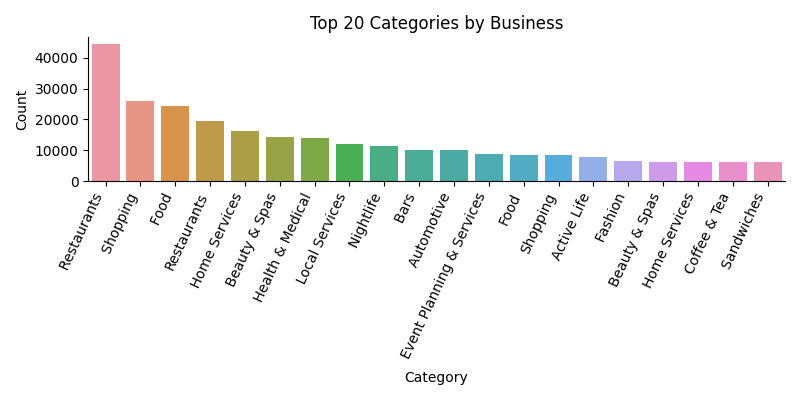

In [11]:
top_20_df = top_20_cats.toPandas()
top_20_df = top_20_df[:20]

ax = sns.factorplot(x = 'category',y='count',data = top_20_df, size = 4, aspect = 2,kind = 'bar')
for axes in ax.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(),rotation=65,horizontalalignment = 'right')
ax.set(xlabel = 'Category',ylabel = 'Count')
plt.title('Top 20 Categories by Business')
plt.tight_layout()
plt.show()
%matplot plt


## 5. Do Yelp Reviews Skew Negative?

In this section, I will review user review data and take a look at some high level review stats

### Loading in User and Reviews Data

After loading in the data, I will review the schema for a quick glance at what the data looks like

In [12]:
user= spark.read.json("s3://sta9760project2/yelp_academic_dataset_user.json")
review = spark.read.json("s3://sta9760project2/yelp_academic_dataset_review.json")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
print('User Dataset')
user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

User Dataset
root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [14]:
print("Review Dataset")
review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Review Dataset
root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

### Average Stars by Business ID

In this dataset, each star rating is associated with a business id, so let's examine what the average stars is for each business.

However, we are only interested in the average reviews for users who also submitted a written review. Before finding the average, I will isolate rows that contain a written review

In [15]:
import pyspark.sql.functions as F
written_review = review.select('business_id','stars','text')
written_review = written_review.withColumn('text_length',F.length(written_review['text']))
all_rev = written_review.count()

textonly_review = written_review.filter(written_review.text_length > 0)
textrev_count = textonly_review.count()

print('All Reviews:',all_rev)
print('Text Only:',textrev_count)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

All Reviews: 8021122
Text Only: 8021122

While there may be some reviews with minimal responses, it appears that every row in the dataset contains a written review of some sort. Because of this, I will use the original review dataset without a filter.

In [16]:
stars_by_biz = review.select('business_id','stars')
stars_by_biz.show(10)
print(stars_by_biz.select('business_id').distinct().count())
print(stars_by_biz.select('business_id').count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
|nlxHRv1zXGT0c0K51...|  5.0|
|Pthe4qk5xh4n-ef-9...|  5.0|
|FNCJpSn0tL9iqoY3J...|  5.0|
|e_BiI4ej1CW1F0EyV...|  5.0|
|Ws8V970-mQt2X9CwC...|  4.0|
+--------------------+-----+
only showing top 10 rows

209393
8021122

In [17]:
avg_stars = stars_by_biz.groupby('business_id').mean()
avg_stars.show(15)
print(avg_stars.select('business_id').distinct().count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|kpbhERZoj1eTDRnMV...| 2.033333333333333|
|ipFreSFhjClfNETuM...|               2.6|
|9A_mB7Ez3RIh26EN5...|               2.6|
|dLDMU8bOLnkDTmPUr...| 4.942857142857143|
|Qm2datcYBPXrPATVG...| 4.352941176470588|
|A8RTiHfw0AfaXQsjN...|               3.2|
|ei7SYxd07uETpASn1...| 4.222222222222222|
|-I06hkMFrX0KBqu61...|               5.0|
|D-CykxLr_NJe1fI4e...|1.9473684210526316|
|Wh9GBMRbEGzGgmrXu...|               3.5|
|IfUkm42SB9D0m_Zbk...| 4.170212765957447|
|VemaMmbrjnhDsU8Zq...|              4.25|
|2YUfXT7A-3rsDdWb_...| 2.574324324324324|
+--------------------+------------------+
only showing top 15 rows

209393

### Joining Business and Review datasets

We now have the average star rating for each business, but the data is associated with each business' unique id. The reviews dataset does not provide the business name associated with each id. However, we know that the business datatset does! Below, I will join the two datasets along the business_id.



In [18]:
stars_by_biz = stars_by_biz.withColumnRenamed('business_id','biz_id')
stars_by_biz.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|              biz_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

In [19]:
# Joining Avg Stars with stars by business id

biz_with_avg = stars_by_biz.join(avg_stars,avg_stars.business_id == stars_by_biz.biz_id)
biz_with_avg.show(10)
biz_with_avg.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+----------------+
|              biz_id|stars|         business_id|      avg(stars)|
+--------------------+-----+--------------------+----------------+
|--9e1ONYQuAa-CB_R...|  5.0|--9e1ONYQuAa-CB_R...|4.11784140969163|
|--9e1ONYQuAa-CB_R...|  5.0|--9e1ONYQuAa-CB_R...|4.11784140969163|
|--9e1ONYQuAa-CB_R...|  5.0|--9e1ONYQuAa-CB_R...|4.11784140969163|
|--9e1ONYQuAa-CB_R...|  2.0|--9e1ONYQuAa-CB_R...|4.11784140969163|
|--9e1ONYQuAa-CB_R...|  2.0|--9e1ONYQuAa-CB_R...|4.11784140969163|
|--9e1ONYQuAa-CB_R...|  5.0|--9e1ONYQuAa-CB_R...|4.11784140969163|
|--9e1ONYQuAa-CB_R...|  5.0|--9e1ONYQuAa-CB_R...|4.11784140969163|
|--9e1ONYQuAa-CB_R...|  5.0|--9e1ONYQuAa-CB_R...|4.11784140969163|
|--9e1ONYQuAa-CB_R...|  5.0|--9e1ONYQuAa-CB_R...|4.11784140969163|
|--9e1ONYQuAa-CB_R...|  4.0|--9e1ONYQuAa-CB_R...|4.11784140969163|
+--------------------+-----+--------------------+----------------+
only showing top 10 rows

8021122

In [20]:
temp_stars = biz_with_avg.select('biz_id','stars','avg(stars)')
biz_info = business.select('business_id','name','city','state')

biz_ratings = biz_info.join(temp_stars,temp_stars.biz_id == biz_info.business_id)
biz_ratings.show(10)
biz_ratings.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------+-----+--------------------+-----+----------------+
|         business_id|                name|     city|state|              biz_id|stars|      avg(stars)|
+--------------------+--------------------+---------+-----+--------------------+-----+----------------+
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|Las Vegas|   NV|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|Las Vegas|   NV|--9e1ONYQuAa-CB_R...|  4.0|4.11784140969163|
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|Las Vegas|   NV|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|Las Vegas|   NV|--9e1ONYQuAa-CB_R...|  3.0|4.11784140969163|
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|Las Vegas|   NV|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|Las Vegas|   NV|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|Las Vegas|   NV|--9e1

In [21]:
unique_biz = biz_info.select('business_id').distinct().count()
print('Number of Unique Businesses with Ratings:', unique_biz)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of Unique Businesses with Ratings: 209393

### Visualizing Data Skewness

We now have readable data that can tell us the average star rating by business name. However, there are over 200,000 businesses in our dataset. The best way to examine the data will be to look at all reviews as a whole, and look for trends in star ratings. I will now look to see if Yelp ratings skew towards a negative bias.

Before visualizing the results, I created a new column to measure skew between the star rating and average rating for each line. After formulating the skew, I passed this data through the MinMaxScaler to normalize/scale the data.


In [22]:
rating_skew = biz_ratings.select('business_id','stars','avg(stars)')
rating_skew = rating_skew.withColumn('skew',((rating_skew['avg(stars)']-rating_skew['stars'])/rating_skew['stars']))
rating_skew.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+----------------+--------------------+
|         business_id|stars|      avg(stars)|                skew|
+--------------------+-----+----------------+--------------------+
|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|-0.17643171806167396|
|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|-0.17643171806167396|
|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|-0.17643171806167396|
|--9e1ONYQuAa-CB_R...|  2.0|4.11784140969163|  1.0589207048458151|
|--9e1ONYQuAa-CB_R...|  2.0|4.11784140969163|  1.0589207048458151|
|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|-0.17643171806167396|
|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|-0.17643171806167396|
|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|-0.17643171806167396|
|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|-0.17643171806167396|
|--9e1ONYQuAa-CB_R...|  4.0|4.11784140969163|0.029460352422907565|
+--------------------+-----+----------------+--------------------+
only showing top 10 rows

In [23]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())
assembler = VectorAssembler(inputCols = ['skew'],outputCol = 'skew_vect')
scaler = MinMaxScaler(inputCol = 'skew_vect',outputCol = 'skew_scaled').setMin(-1.0).setMax(1.0)
pipeline = Pipeline(stages=[assembler,scaler])
rating_skew_scaled = pipeline.fit(rating_skew).transform(rating_skew).withColumn('skew_scaled',
                                                                                 unlist('skew_scaled')).drop('skew_vect')

rating_skew_scaled.show(10)




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+----------------+--------------------+-----------+
|         business_id|stars|      avg(stars)|                skew|skew_scaled|
+--------------------+-----+----------------+--------------------+-----------+
|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|-0.17643171806167396|     -0.745|
|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|-0.17643171806167396|     -0.745|
|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|-0.17643171806167396|     -0.745|
|--9e1ONYQuAa-CB_R...|  2.0|4.11784140969163|  1.0589207048458151|     -0.226|
|--9e1ONYQuAa-CB_R...|  2.0|4.11784140969163|  1.0589207048458151|     -0.226|
|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|-0.17643171806167396|     -0.745|
|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|-0.17643171806167396|     -0.745|
|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|-0.17643171806167396|     -0.745|
|--9e1ONYQuAa-CB_R...|  5.0|4.11784140969163|-0.17643171806167396|     -0.745|
|--9e1ONYQuAa-CB_R...|  4.0|4.11784140969163|0.02946

In [24]:
rating_skew_scaled.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

8021122

In [25]:
rating_skew_only = rating_skew_scaled.select('skew','skew_scaled')
rating_temp = rating_skew_only.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

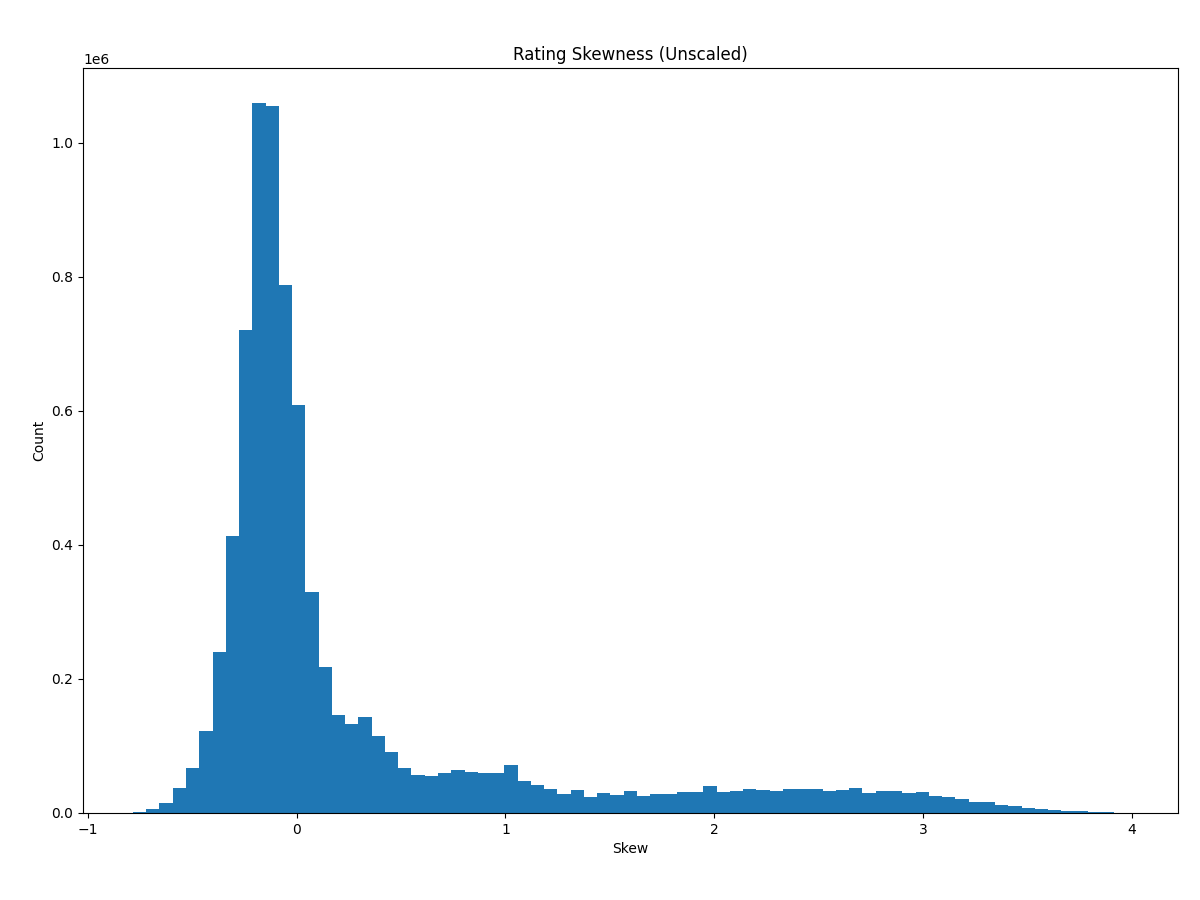

In [27]:
skew = rating_temp['skew']

ax = plt.hist(skew,bins = 75)
plt.tight_layout()
plt.xlabel('Skew')
plt.ylabel('Count')
plt.title('Rating Skewness (Unscaled)')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12,9)
plt.show()
%matplot plt

In [28]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

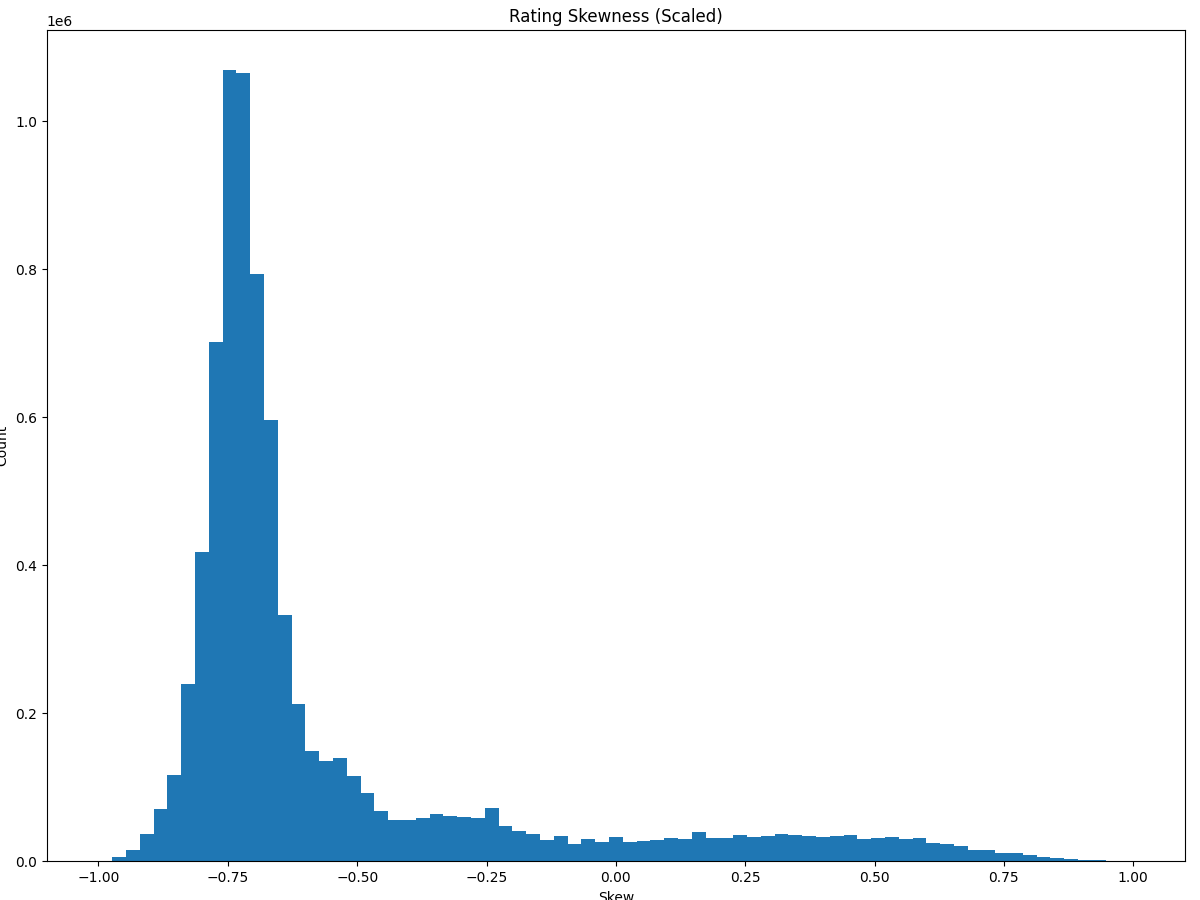

In [29]:
skew_scale = rating_temp['skew_scaled']

ax = plt.hist(skew_scale,bins = 75)
plt.tight_layout()
plt.xlabel('Skew')
plt.ylabel('Count')
plt.title('Rating Skewness (Scaled)')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12,9)
plt.show()
%matplot plt

In [30]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 6. Looking at Elite Yelpers

#### There are several users in the yelp system that are designated as "elite." I am curious to know how there reviews compare to the average. In order to do this, I will join the user and review datasets

In [31]:
user= spark.read.json("s3://sta9760project2/yelp_academic_dataset_user.json")
review = spark.read.json("s3://sta9760project2/yelp_academic_dataset_review.json")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
user.printSchema()
review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

root
 |-- business_id: string (nullable = true)
 |-- cool: long (null

In [33]:
import pyspark.sql.functions as F
total_user = user.count()

elite_temp = user.select('user_id','elite')
elite_user = elite_temp.filter(F.length(elite_temp['elite']) > 0)
elite_user = elite_user.select('user_id','elite')
elite_count = elite_user.count()
print('Total number of users:',total_user)
print('Number of Elite users',elite_count)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total number of users: 1968703
Number of Elite users 75961

According to the data, there are over 75,000 "elite" users counted in this dataset. Do their reviews also skew negative against the average? Let's find out

In [42]:
review_temp = review.select('business_id','user_id','stars')
review_temp = review_temp.withColumnRenamed('business_id','biz_id')
review_temp = review_temp.withColumnRenamed('user_id','user_id1')

elite_review = elite_user.join(review_temp, review_temp.user_id1 == elite_user.user_id)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
elite_review.show(5)
elite_review.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+--------------------+--------------------+-----+
|             user_id|              elite|              biz_id|            user_id1|stars|
+--------------------+-------------------+--------------------+--------------------+-----+
|1Dul59QEe-Q-7OQHT...|               2017|-8F04F54iDT6VgWPC...|1Dul59QEe-Q-7OQHT...|  4.0|
|3pMczoCBOSKBcqMhV...|               2017|p2OOk46G_AOO0nCWl...|3pMczoCBOSKBcqMhV...|  5.0|
|jO44Apni7iJZVVK4H...|2010,2011,2012,2013|jyFoxS8MofdpkAAK6...|jO44Apni7iJZVVK4H...|  1.0|
|RO78oDy7vbEcOJU8a...|          2017,2018|ewty6EB70nwPJsUkA...|RO78oDy7vbEcOJU8a...|  4.0|
|TFxeEvpjMNQ3AWL49...|          2017,2018|0M3KCmdY-_xlIu5vE...|TFxeEvpjMNQ3AWL49...|  5.0|
+--------------------+-------------------+--------------------+--------------------+-----+
only showing top 5 rows

1756327

In [44]:
elite_avg = elite_review.groupby('biz_id').mean()
elite_avg = elite_avg.withColumnRenamed('biz_id','biz_id1')

elite_avg.show(5)
elite_avg.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|             biz_id1|        avg(stars)|
+--------------------+------------------+
|VHsNB3pdGVcRgs6C3...|               4.0|
|-I06hkMFrX0KBqu61...|               5.0|
|RMjCnixEY5i12Ciqn...|3.3461538461538463|
|ipFreSFhjClfNETuM...|3.0588235294117645|
|Qm2datcYBPXrPATVG...| 4.666666666666667|
+--------------------+------------------+
only showing top 5 rows

148225

In [45]:
elite_review2 = elite_review.join(elite_avg, elite_avg.biz_id1 == elite_review.biz_id)
elite_review3 = elite_review2.select('biz_id','user_id','stars','avg(stars)')
elite_review3 = elite_review3.withColumnRenamed('avg(stars)','elite_avg')
elite_review3.show(5)
elite_review3.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----+------------------+
|              biz_id|             user_id|stars|         elite_avg|
+--------------------+--------------------+-----+------------------+
|VHsNB3pdGVcRgs6C3...|Yximlvn0cfb3yVDaL...|  5.0|               4.0|
|-I06hkMFrX0KBqu61...|1PfEtkSwdXiyeIqEx...|  5.0|               5.0|
|VHsNB3pdGVcRgs6C3...|WJdXYIM5cphh_28C5...|  4.0|               4.0|
|RMjCnixEY5i12Ciqn...|YscRH0PIhAxwehaTu...|  2.0|3.3461538461538463|
|RMjCnixEY5i12Ciqn...|KvNTqEG5tUDyrhX4o...|  3.0|3.3461538461538463|
+--------------------+--------------------+-----+------------------+
only showing top 5 rows

1756327

From the above code, we now have the average star rating for each business based solely on reviews from "elite" users. But how does this compare to the average business rating from all yelp users? To look at this, I will create a new table with the following columns:
    - business id
    - average star rating (all users)
    - average star rating (elite only)
    - rating skewness

In [48]:
biz_ratings.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

8021122

In [49]:
elite_temp1 = elite_review3.select('biz_id','elite_avg')

biz_elite_test = elite_temp1.join(biz_ratings, elite_temp1.biz_id == biz_ratings.business_id)
biz_elite_test = biz_elite_test.select('business_id','name','city','state','stars','avg(stars)','elite_avg')
biz_elite_test.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------+-----+-----+----------------+------------------+
|         business_id|                name|     city|state|stars|      avg(stars)|         elite_avg|
+--------------------+--------------------+---------+-----+-----+----------------+------------------+
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|Las Vegas|   NV|  4.0|4.11784140969163|4.1916058394160585|
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|Las Vegas|   NV|  5.0|4.11784140969163|4.1916058394160585|
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|Las Vegas|   NV|  4.0|4.11784140969163|4.1916058394160585|
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|Las Vegas|   NV|  4.0|4.11784140969163|4.1916058394160585|
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|Las Vegas|   NV|  5.0|4.11784140969163|4.1916058394160585|
+--------------------+--------------------+---------+-----+-----+----------------+------------------+
only showing top 5 rows

In [51]:
biz_elite_test = biz_elite_test.select('business_id','avg(stars)','elite_avg').distinct()
biz_elite_test.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

148225

In [52]:
elite_skew = biz_elite_test.select('business_id','avg(stars)','elite_avg')
elite_skew = elite_skew.withColumnRenamed('avg(stars)','total_avg')
elite_skew = elite_skew.withColumn('elite_skew',(elite_skew['elite_avg']-elite_skew['total_avg'])/elite_skew['total_avg'])

elite_skew.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+------------------+--------------------+
|         business_id|         total_avg|         elite_avg|          elite_skew|
+--------------------+------------------+------------------+--------------------+
|--9e1ONYQuAa-CB_R...|  4.11784140969163|4.1916058394160585| 0.01791337314516737|
|--phjqoPSPa8sLmUV...|              3.75|               4.0| 0.06666666666666667|
|--q7kSBRb0vWC8lSk...|               4.0|               4.0|                 0.0|
|-0ZO00Vm2ADchytlE...| 4.976744186046512|               5.0|0.004672897196261691|
|-1VaIJza42Hjev6uk...|3.8107142857142855| 3.793103448275862|-0.00462140063988...|
+--------------------+------------------+------------------+--------------------+
only showing top 5 rows

In [53]:
elite_skew1 = elite_skew.select('total_avg','elite_skew')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
elite_pd = elite_skew1.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

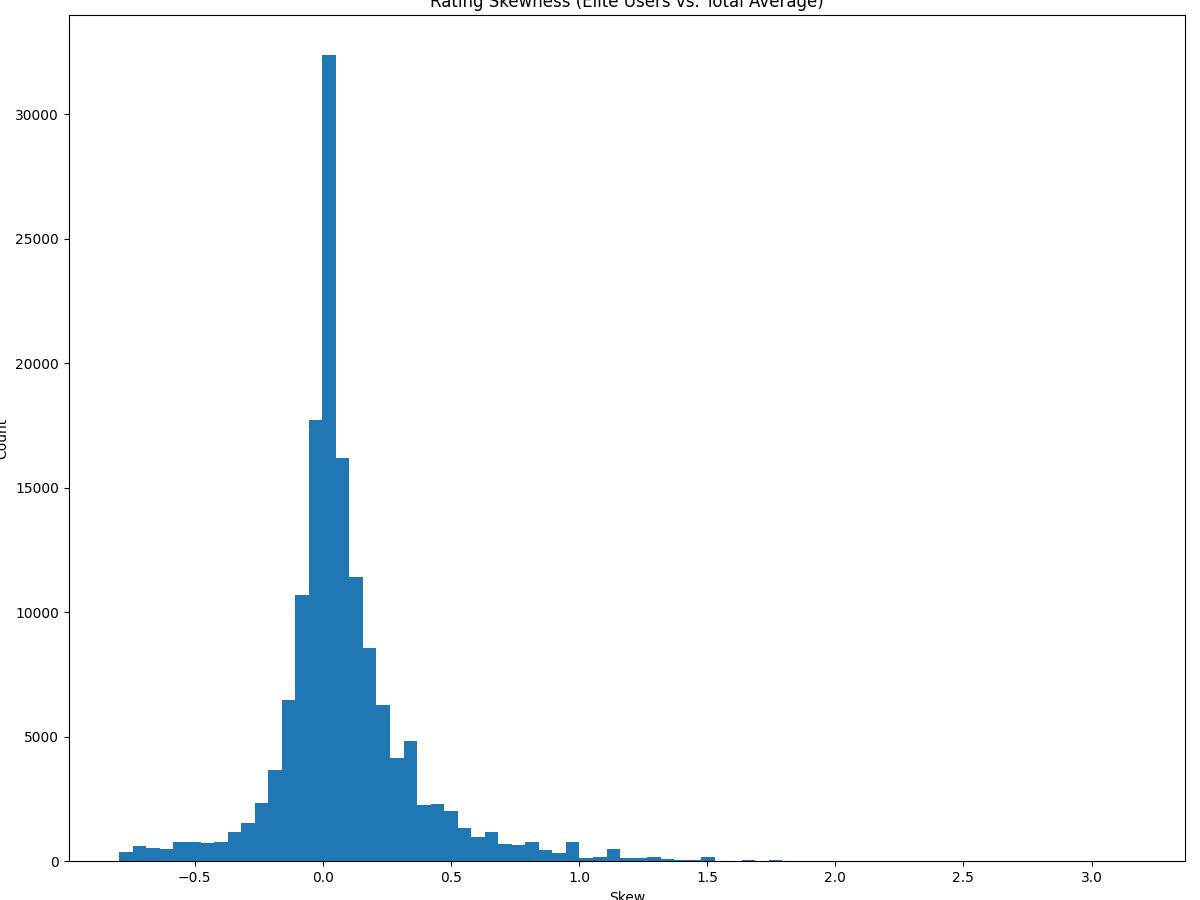

In [56]:
skew = elite_pd['elite_skew']

ax = plt.hist(skew,bins = 75)
plt.tight_layout()
plt.xlabel('Skew')
plt.ylabel('Count')
plt.title('Rating Skewness (Elite Users vs. Total Average)')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12,9)
plt.show()
%matplot plt

Based on this chart, reviews from Elite users appear to skew in a more standardized distribution (possibly even positive!). This chart shows us that reviews from elite users appear to trend closer to the average than all users. Reviews from all users have a definitively more negative bias than elite users.